In [6]:
pwd

'C:\\Users\\Tiger\\Desktop\\ECE5242 Project1'

1 cone in X_cone_hsv.npy

3 bg in X_bg_hsv.py

ideas from TA comment in Ed Discussion: 1 cone 3 bg for GMM training

### Load data

In [158]:
import cv2, os
import numpy as np

X_cone = np.load("X_cone_hsv.npy")
X_bg = np.load("X_bg_hsv.npy")

print(X_cone.shape, X_bg.shape)
print(X_cone.dtype, X_bg.dtype)

(96524, 3) (2513682, 3)
uint8 uint8


npy file uint8（0~255）need astype(np.float64) incase overflow

### for each class（cone / background), train a GMM：
- p(x | cone)
- p(x | bg)

Log Likelihood
Expectation-Maximization (EM): E-step: lower bound, M step: weighted averages

iterate until Log likelihood converge

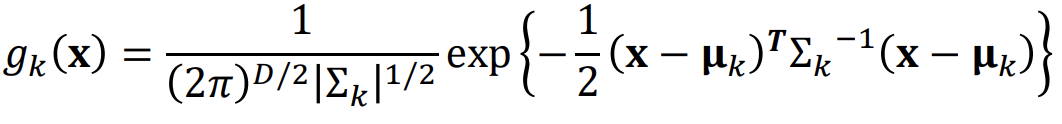
[cite from class slides Lec04_GMM.pdf]

In [159]:
# Gaussian density g_k(x|μk,Σk) D dimention Gaussian probability density
# 像素x在第k个颜色簇里有多像
# eps=1e-6 in case non-invertible or determinant = 0
def gaussian_pdf(X, mu, Sigma, eps=1e-6):
    """
    calculate g(x|mu,Sigma) for each x in X
    X: (N,D)
    mu: μ
    Sigma: Σ
    """
    # npy file uint8（0~255）need astype(np.float64) incase overflow
    X = X.astype(np.float64)
    mu = mu.astype(np.float64)
    Sigma = Sigma.astype(np.float64)

    N, D = X.shape # Dimention = 3; H,S,V

    Sigma = Sigma + eps * np.eye(D) # in case not invertable
    
    invS = np.linalg.inv(Sigma) # inverse matrix 逆矩阵
    detS = np.linalg.det(Sigma) # determinant 行列式

    diff = X - mu                              # diff to mean; shape (N,D)
    
    # 计算二次型 (x-μ)^T invS (x-μ) for each sample; "v^T * A * v"
    quad = np.sum((diff @ invS) * diff, axis=1)  # (N,) how far to mean

    coef = 1.0 / ((2*np.pi) **(D/2) * (detS**0.5)) # 归化一常数coefficient
    return coef * np.exp(-0.5 * quad) # return vector in (N,)

### E-step lower bound
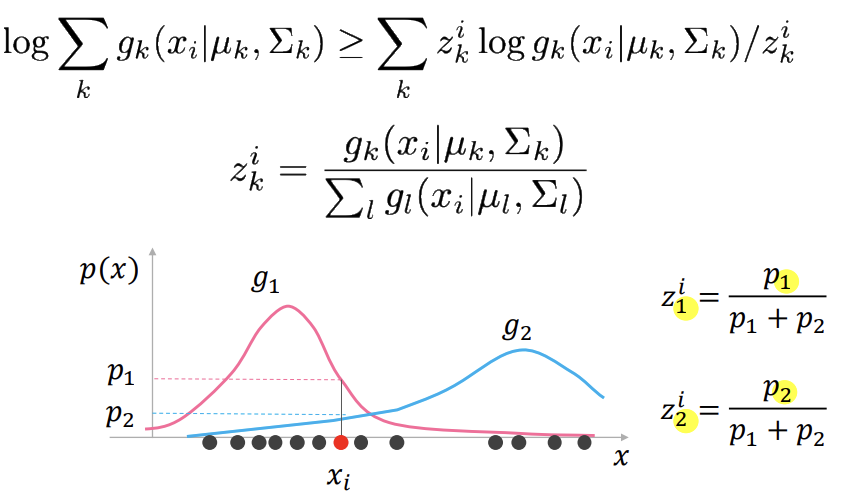
[cite from class slides Lec05_Logistic.pdf]

In [160]:
# E step
# responsibility: weight/ratio z_i_k

def estep(X, w, mu, Sigma):
    
    # npy file uint8（0~255）need astype(np.float64) incase overflow
    X = X.astype(np.float64)
    K = w.shape[0] # (K,) how many gaussion part
    N = X.shape[0] # X(N,D), X.shape[0] is N; N pixel sample; X.shape[1] is D

    # calculate P[i,k] = w_k * g_k(x_i)  shape (N,K)
    P = np.zeros((N,K),dtype=np.float64) # create form N row a sample x_i, K colomn with gaussion part k
    for k in range(K):
        g = gaussian_pdf(X, mu[k], Sigma[k])
        P[:,k] = w[k] * g # fill k-th colomn with P[i,k] = w_k * g_k(x_i)

    # normalize each row so sum_k Z[i,k] = 1
    row_sum = np.sum(P, axis=1, keepdims=True) # sum of each row is denumerator; keepdims=True shape it in (N,1)
    Z = P / row_sum # use function
    return Z

### M step
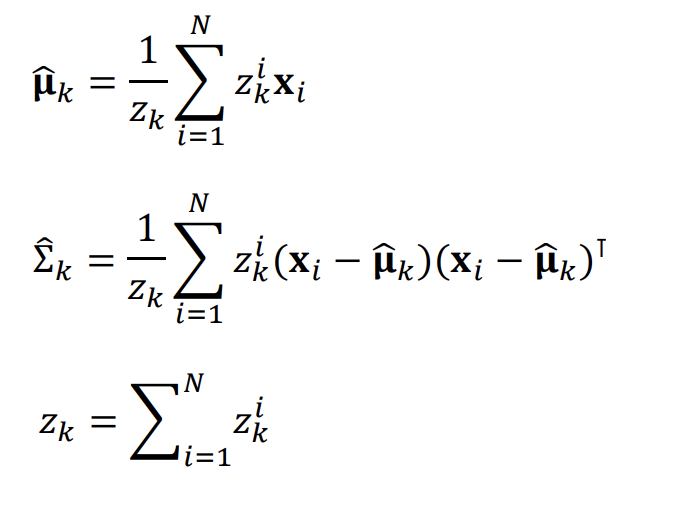
[cite from class slides Lec04_GMM.pdf]

In [161]:
# M step

def mstep(X, Z, eps=1e-6):
    """
    update parameters w, mu, Sigma
    
    return:
      w_new: (K,)
      mu_new: (K,D)
      Sigma_new: (K,D,D)
    """
    
    # npy file uint8（0~255）need astype(np.float64) incase overflow
    X = X.astype(np.float64)
    N, D = X.shape
    K = Z.shape[1]

    zk = np.sum(Z, axis=0)  # (K,)

    # update mixing weights
    w_new = zk / N

    # update mean: mu_new[k] k-th cluster weight center
    # Z.T @ X: (K,N)@(N,D) -> (K,D) matrix multiplex @
    mu_new = (Z.T @ X) / zk[:, None] # zk[:, None] turn (K,) into (K,1)

    # update covariance for each k: Sigma_new[k] is k-th cluster weight covariance
    Sigma_new = np.zeros((K, D, D)) # covariance matrix Σ_k is DxD - 3x3

    for k in range(K): # calculate covariance based on new μ_k, z_i_k
        diff = X - mu_new[k]
        Sigma_new[k] = (Z[:, k][:, None] * diff).T @ diff / zk[k]
        Sigma_new[k] += eps * np.eye(D) # add small eps 1e-6 incase Σ_k not invertable

    return w_new, mu_new, Sigma_new

### EM Loop
- E step calculate Z weight
- M step update w, mu, Sigma

In [162]:
def em_loop(X, K=3, max_iter=30, seed=666):
    """
    Train one GMM using EM
    K个cluster cone or bg的颜色分布,可调
    max_iter迭代次数
    X: (N,D)
    return: w (K,), mu (K,D), Sigma (K,D,D)
    """
    # npy file uint8（0~255）need astype(np.float64) incase overflow
    X = X.astype(np.float64)
    N, D = X.shape
    rng = np.random.default_rng(seed) # random number generator from seed

    # init: weights uniform 均分1/K权重数组; np.ones(3) -> [1, 1, 1]
    w = np.ones(K) / K  # [1/3, 1/3, 1/3]

    # init: choose K random points from N to calculate means; replace=False means no repeat points
    mu = X[rng.choice(N, size=K, replace=False)]

    # init: all components share same covariance = overall covariance
    # X.T -> (D, N): H/S/V, N pixel samples, so output is D x D matrix
    # add 1e-3 to eye on covariance matrix in case error
    cov0 = np.cov(X.T) + 1e-3 * np.eye(D)

    # begin with Σ_1 = Σ_2 = ⋯ = Σ_K = cov0
    # create cov0.copy list and stack together on 0 dimension and get shape (K,D,D)
    Sigma = np.stack([cov0.copy() for _ in range(K)], axis=0) 

    
    # EM Loop based on max_iter times
    for it in range(max_iter):
        Z = estep(X, w, mu, Sigma)
        w, mu, Sigma = mstep(X, Z)

    return w, mu, Sigma

### Train cone and bg two GMM and save
only need to train once

In [163]:
import numpy as np

# load labeled HSV pixels again (uint8)
X_cone = np.load("X_cone_hsv.npy")  # (96828, 3)
X_bg   = np.load("X_bg_hsv.npy")    # (1436586, 3)

# train two GMM models. Bg have more data so can have more cluster. Tuned
w_c, mu_c, Sig_c = em_loop(X_cone, K=3, max_iter=30, seed=666)
w_b, mu_b, Sig_b = em_loop(X_bg,   K=5, max_iter=30, seed=666)

# save model paramters: only need to train once
np.savez("gmm_cone_bg_hsv.npz",
         w_c=w_c, mu_c=mu_c, Sig_c=Sig_c,
         w_b=w_b, mu_b=mu_b, Sig_b=Sig_b)

In [253]:
# load model
model = np.load("gmm_cone_bg_hsv.npz")
w_c, mu_c, Sig_c = model["w_c"], model["mu_c"], model["Sig_c"]
w_b, mu_b, Sig_b = model["w_b"], model["mu_b"], model["Sig_b"]

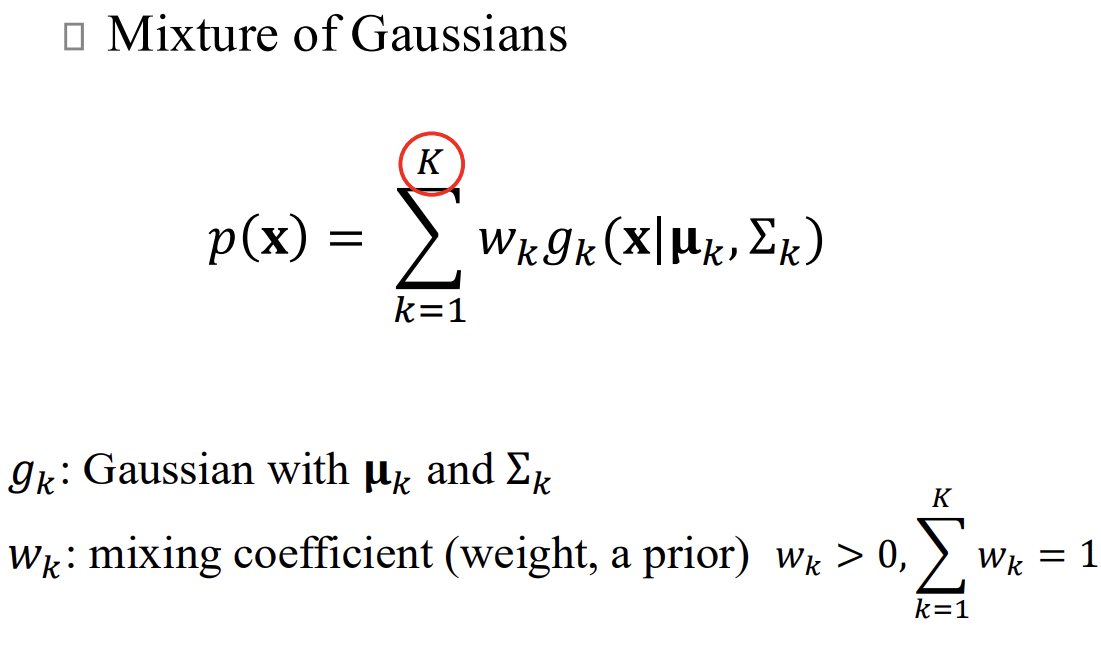
[cite from class slides Lec04_GMM.pdf]

In [254]:
import cv2, os
import numpy as np

In [255]:
def gmm_pdf(X, w, mu, Sigma):
    """
    Compute mixture density p(x)
    X: (N,D)
    w: (K,)
    mu: (K,D)
    Sigma: (K,D,D)
    return: p (N,)
    """

    # npy file uint8（0~255）need astype(np.float64) incase overflow
    X = X.astype(np.float64)
    K = w.shape[0] # (K,) how many gaussion part
    N = X.shape[0] # X(N,D), X.shape[0] is N; N pixel sample; X.shape[1] is D

    # create a array length of N
    # p[i] is i-th sample mixture density
    p = np.zeros(N, dtype=np.float64)
    for k in range(K): # for every gaussion part, cumulate p += w[k] * g
        p += w[k] * gaussian_pdf(X, mu[k], Sigma[k])  # (N,)
    return p

### segment_mask, output mask
对一张图做像素分类，输出mask黑白图 0/1 表是否跟cone/bg有关
- p(x|cone)
- p(x|bg)

In [256]:
import cv2

def segment_mask(img_bgr, w_c, mu_c, Sig_c, w_b, mu_b, Sig_b, alpha=30.0):
    """
    input:
        img_bgr: (H,W,3) OpenCV read BGR image
        cone GMM: w_c, mu_c, Sig_c
        bg GMM: w_b, mu_b, Sig_b
    output:
        mask: (H,W) 0/1 matrix（black/white image）
        1 represent cone pixel
        0 represent background pixel
    """

    # turn image from BGR to HSV
    img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)  # (H,W,3)

    # get size
    H, W, _ = img_hsv.shape

    # turn every pixel into sample x=(H,S,V)
    X = img_hsv.reshape(-1, 3)  # get (N,3); N=H*W

    # use cone GMM to calculate every pixel density: p(x|cone)
    p_cone = gmm_pdf(X, w_c, mu_c, Sig_c)   # (N,)

    # use bg GMM to calculate each pixel density: p(x|bg)
    p_bg = gmm_pdf(X, w_b, mu_b, Sig_b)    # (N,)


    # pixel segment: more density means more like cone/bg
    # (p_cone > p_bg) get True/False, turn into 1/0; white is cone
    # do N comparison at the same time in array; Vectorized operations
    # tuned p_cone > alpha * p_bg to count as cone
    mask_flat = (p_cone > alpha* p_bg).astype(np.uint8) # (N,) 0/1 ; !!! Tune alpha

    mask = mask_flat.reshape(H,W) # (N,) result reshape to original shape (H,W)

    return mask

### Test one picture and show result

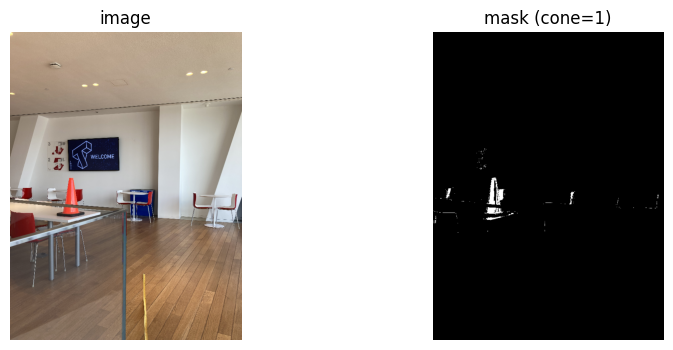

In [257]:
# import matplotlib.pyplot as plt
# import cv2

# img_path = "ECE5242Proj1-train/train_2_dist305.png"
# img = cv2.imread(img_path)  # BGR

# mask = segment_mask(img, w_c, mu_c, Sig_c, w_b, mu_b, Sig_b, alpha=20.0)

# plt.figure(figsize=(10,4))

# plt.subplot(1,2,1)
# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
# plt.title("image")
# plt.axis("off")

# plt.subplot(1,2,2)
# plt.imshow(mask, cmap="gray")
# plt.title("mask (cone=1)")
# plt.axis("off")

# plt.show()

### connected components

In [258]:
def find_components(mask01, min_area=300): # min pixel use to filter small piece noise
    """
    mask01: (H,W) 0/1
    return list of boxes: (x,y,w,h)
    """
    mask01 = (mask01 > 0).astype(np.uint8) # make sure it's unit8 (0/1)
    
    # usage cite from OpenCV documentation
    # cv2.connectedComponentsWithStats() return retval, labels, stats, centroids 返回值、标签、统计信息、质心
    # stats[i] = [x, y, w, h, area] : i-th connected components info
    # [xy左上角axis,width,height,area:pixel number]
    num, labels, stats, centroids = cv2.connectedComponentsWithStats(mask01, connectivity=8)
    
    boxes = []  #store [(x1, y1, x2, y2, area),(x1, y1, x2, y2, area),...]
    for i in range(1, num):  # skip 0 the biggest black background
        x, y, w, h, area = stats[i] 
        if h > w and area >= min_area: # cone's h > w and filter noise
            boxes.append((x, y, x+w-1, y+h-1, area)) # turn (x, y, w, h) into (x1, y1, x2, y2)
    return boxes

In [259]:
def merge_boxes_simple(boxes, x_th=25):
    """
    Merge boxes that are close.
    boxes: [(x1,y1,x2,y2,area), ...] (x1,y1)(x2,y2)左上右下角坐标的框
    return: [(x1,y1,x2,y2), ...] merged
    """
    if len(boxes) == 0:
        return []

    merged = []  # # each element is [x1,y1,x2,y2,cx]
    
    for (x1,y1,x2,y2,area) in boxes:
        cx = 0.5*(x1+x2) # calculate center x 'cx' 

        placed = False  # False means not merged yet
        for m in merged: # 
            if abs(cx - m[4]) < x_th: # if |current cx - merged_center| < threshold, it's same cone
                # merge into this group
                m[0] = min(m[0], x1) # 左上角取更小的 x/y
                m[1] = min(m[1], y1)
                m[2] = max(m[2], x2) # 右下角取更大的 x/y
                m[3] = max(m[3], y2)
                
                m[4] = 0.5*(m[0]+m[2]) # update group center (average, simple)
                
                placed = True # count as merged already
                break # then stop finding

        if not placed: # create new cone group
            merged.append([x1,y1,x2,y2,cx])

    return [tuple(m[:4]) for m in merged] # m[:4] means only return first 4 elements and no need area

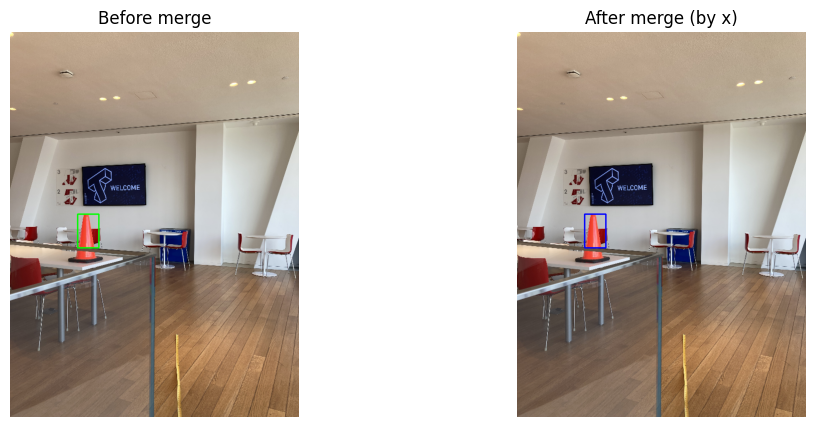

In [260]:
# img_path = "ECE5242Proj1-train/train_2_dist305.png"
# img = cv2.imread(img_path)

# mask = segment_mask(img, w_c, mu_c, Sig_c, w_b, mu_b, Sig_b)

# boxes = find_components(mask, min_area=200)
# boxes_m = merge_boxes_simple(boxes, x_th=25)

# vis1 = draw_boxes(img, boxes,  color=(0,255,0), thick=2)
# vis2 = draw_boxes(img, boxes_m, color=(255,0,0), thick=2)

# plt.figure(figsize=(12,5))
# plt.subplot(1,2,1); plt.imshow(cv2.cvtColor(vis1, cv2.COLOR_BGR2RGB)); plt.title("Before merge"); plt.axis("off")
# plt.subplot(1,2,2); plt.imshow(cv2.cvtColor(vis2, cv2.COLOR_BGR2RGB)); plt.title("After merge (by x)"); plt.axis("off")
# plt.show()


### Get distance from filename and get h_pix
- bbox = bounding box（外接矩形框）

In [261]:
import re

def parse_dists_cm(filename):
    """
    filename like: train_2_dist305.png
    return: 305.0 (cm)
    """
    m = re.search(r"dist(\d+)", filename)
    if not m:
        return None
    return float(m.group(1)) # group(1) 得到第一组匹配结果

def bbox_height(b): 
    x1, y1, x2, y2 = b
    return (y2 - y1 + 1) # return y axis height

def bbox_base_point(b):
    x1, y1, x2, y2 = b
    right = int((x1 + x2) / 2)
    down  = int(y2)
    return down, right

In [262]:
def fit_a(train_folder):
    """
    a = mean(d_cm * h_pix) over training images
    multiple images get average a
    """
    dh = []
    # list all file end with png and sort
    names = [n for n in os.listdir(train_folder) if n.endswith(".png")]
    names.sort()

    for fn in names:
        d = parse_dists_cm(fn) # get distance from filename fn
        if d is None:
            continue # skip if None

        img = cv2.imread(os.path.join(train_folder, fn)) # read image
        mask = segment_mask(img, w_c, mu_c, Sig_c, w_b, mu_b, Sig_b) # segment_mask
        boxes = find_components(mask)              # uses default min_area=200
        bboxes = merge_boxes_simple(boxes)         # uses default x_th=25

        if len(bboxes) == 0:
            continue

        b = max(bboxes, key=bbox_height)           # one cone per train image
        h = bbox_height(b)
        dh.append(d * h)

    return float(np.mean(dh))

In [263]:
def predict_train_one(img_bgr, a, min_area=200, x_th=30):
    """
    training set: 1 real cone per image
    pick the tallest bbox to avoid reflection
    return (down,right,dist) or None
    """
    mask = segment_mask(img_bgr, w_c, mu_c, Sig_c, w_b, mu_b, Sig_b, alpha=20.0)
    boxes = find_components(mask, min_area=min_area) # (x1,y1,x2,y2,area)
    bboxes = merge_boxes_simple(boxes, x_th=x_th)  # (x1,y1,x2,y2)

    if len(bboxes) == 0:
        return None

    # pick tallest bbox
    b = max(bboxes, key=bbox_height)
    down, right = bbox_base_point(b)
    dist = a / float(bbox_height(b)) # pre dict distance model
    return down, right, dist

In [265]:
# “Run file” that write results.txt
import os
import cv2

def run_folder_to_results(folder, out_txt, a, min_area=200, x_th=30):
    """
    folder: image path
    out_txt: name of output text: "results.txt"
    a: coefficient from distance model (d = a / h_pix)
    min_area: filter small noise connected component
    x_th: threshold of merge connected component
    """

    # list all file end with png and sort
    names = [n for n in os.listdir(folder) if n.endswith(".png")]
    names.sort()

    # open out_txt and overwrite/regenerate
    with open(out_txt, "w") as f:
        for fn in names:
            # read each image
            # do whole process (segment mask -> connect components get boxes -> merge get bboxes
            #  -> calculate each bbox base point + distance)
            img = cv2.imread(os.path.join(folder, fn))
            pred = predict_train_one(img, a, min_area=min_area, x_th=x_th)

            if pred is None: # if no cone write -1 -1 -1
                f.write(f"{fn} -1 -1 -1\n")
            else:
                down, right, dist = pred
                # look like ImageName:test_1.png, Down: 300.02, Right: 200.05, Distance: 450.6
                f.write(f"ImageName:{fn}, Down: {down:.2f}, Right: {right:.2f}, Distance: {dist:.2f}\n")

In [266]:
# run
a = fit_a("ECE5242Proj1-train")

np.savez("gmm_cone_bg_hsv.npz",
         w_c=w_c, mu_c=mu_c, Sig_c=Sig_c,
         w_b=w_b, mu_b=mu_b, Sig_b=Sig_b,
         a=a) # save model again with calculated a

run_folder_to_results("ECE5242Proj1-train", "results_train.txt", a)